# Семинар 7

# Введение в итерационные методы

## Степенной метод: напоминание

- Задача поиска максимального по модулю собственного значения
- Сходимость линейная, коэффициент $\frac{|\lambda_2|}{|\lambda_1|}$
- Может не сходится. В каком случае?
- Сложность пропорциональна сложности умножения матрицы на вектор

## Сдвиги для ускорения сходимости степенного метода

- Метод обратной итерации со сдвигами

\begin{align*}
& x_{k+1} = (A - \sigma I)^{-1} x_k\\
& x_{k+1} := \frac{x_{k+1}}{\|x_{k+1}\|}
\end{align*}

- Куда сойдётся?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
import scipy.linalg as splin

def shift_inverse_iteration(A, x0, num_iter, shift=0.):
    x = x0.copy()
    conv = [x]
    for i in range(num_iter):
        x = np.linalg.solve(A - shift * np.eye(n), x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

def shift_inverse_iteration_fast(A, x0, num_iter, shift=0.):
    x = x0.copy()
    conv = [x]
    lu_factor = splin.lu_factor(A - shift * np.eye(n))
    for i in range(num_iter):
        x = splin.lu_solve(lu_factor, x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

In [3]:
n = 10
A = np.random.randn(n, n)
A = A.T @ A + np.eye(n)
# A = A + A.T
true_spectrum = np.linalg.eigvals(A)
print(np.sort(true_spectrum))
x0 = np.random.randn(n)
num_iter = 40

[ 1.00129089  1.14452777  1.72651117  4.27990214  5.59525073  8.50188201
 12.20387858 13.17684228 15.93954198 32.29176751]


In [4]:
# smallest_eigv, conv_sm = shift_inverse_iteration(A, x0, num_iter)
# print(smallest_eigv @ A @ smallest_eigv)
smallest_eigv, conv_sm = shift_inverse_iteration_fast(A, x0, num_iter)
print(smallest_eigv @ A @ smallest_eigv)

1.0012950263476652


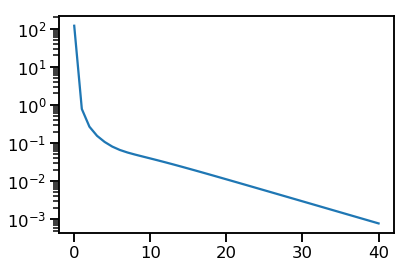

In [5]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_sm])

In [6]:
shift = 3
middle_eigv, conv_m = shift_inverse_iteration(A, x0, num_iter, shift)
print(middle_eigv @ A @ middle_eigv)

2.7309762959740826


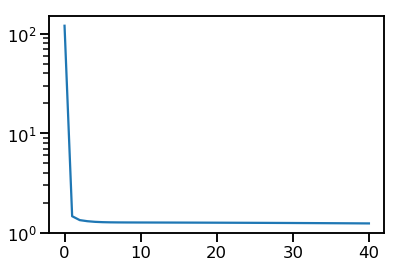

In [7]:
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_m])

In [8]:
shift = 30
large_eigv, conv_l = shift_inverse_iteration(A, x0, num_iter, shift)
print(large_eigv @ A @ large_eigv)

32.29176750885745


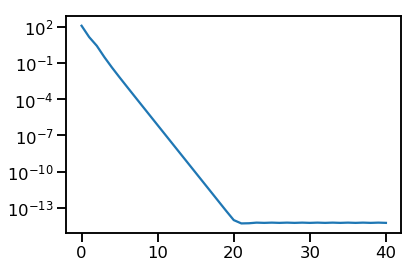

In [9]:
res = np.array([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_l])
plt.semilogy(res)

## Метод Релея

- Адаптивный сдвиг на каждой итерации

$$ \sigma_k = \frac{(Ax_k, x_k)}{(x_k, x_k)} $$

In [10]:
def rayleigh_quotient_iteration(A, x0, num_iter):
    x = x0.copy()
    x = x / np.linalg.norm(x)
    conv = [x]
    
    for i in range(num_iter):
        lam = x @ A @ x
        x = np.linalg.solve(A - lam * np.eye(n), x)
        x = x / np.linalg.norm(x)
        conv.append(x)
    return x, conv

In [11]:
eigv_rq, conv_rq = rayleigh_quotient_iteration(A, x0**2, num_iter)

In [12]:
print(eigv_rq @ A @ eigv_rq)
print(np.sort(np.linalg.eigvals(A)))
print(x0)

4.279902142247673
[ 1.00129089  1.14452777  1.72651117  4.27990214  5.59525073  8.50188201
 12.20387858 13.17684228 15.93954198 32.29176751]
[-0.66949928  0.47543029  0.88485231 -0.14937946 -1.50683479  0.50107061
 -1.98957823 -0.20772708 -1.4726692   0.74007251]


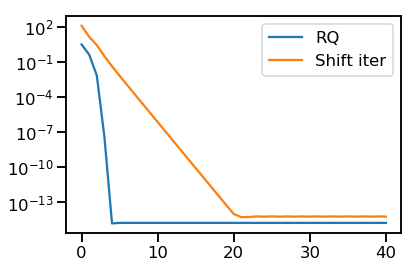

In [13]:
res = np.array([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_rq])
plt.semilogy(res, label="RQ")
plt.semilogy([np.linalg.norm(A @ x - (x @ A @ x) * x) for x in conv_l], label="Shift iter")
plt.legend()

## Как найти другие собственные значения?



In [14]:
B = A - eigv_rq @ (A @ eigv_rq) * np.outer(eigv_rq, eigv_rq)
print(np.sort(np.linalg.eigvals(B)))

[-1.71428299e-15  1.00129089e+00  1.14452777e+00  1.72651117e+00
  5.59525073e+00  8.50188201e+00  1.22038786e+01  1.31768423e+01
  1.59395420e+01  3.22917675e+01]


In [15]:
eigv_rq_B, conv_rq_B = rayleigh_quotient_iteration(B, x0, num_iter)
print(eigv_rq_B @ B @ eigv_rq_B)

1.726511169331873


In [16]:
C = B - eigv_rq_B @ (A @ eigv_rq_B) * np.outer(eigv_rq_B, eigv_rq_B)
print(np.sort(np.linalg.eigvals(C)))

[-1.56067399e-15  3.01144918e-15  1.00129089e+00  1.14452777e+00
  5.59525073e+00  8.50188201e+00  1.22038786e+01  1.31768423e+01
  1.59395420e+01  3.22917675e+01]


In [17]:
eigv_rq_C, conv_rq_C = rayleigh_quotient_iteration(C, x0, num_iter)
print(eigv_rq_C @ C @ eigv_rq_C)

1.0012908945395032


### И так далее для других собственных векторов....

- Какая правильная стратегия использования метода Релея?

## Оптимальный шаг в методе Ричардсона

- Решение линейной системы 

$$ Ax = b $$

- Метод Ричардсона 

$$ x_{k+1} = x_k - \tau (Ax_k - b) = (I - \tau A)x_k + \tau b$$

- Оптимальный $\tau$ для $A = A^* \succ 0$

$$ \tau^* = \frac{2}{\lambda_{\max} + \lambda_{\min}} $$

#### Как его получить?

- Найдём минимум $\| I - \tau A \|_2 = \lambda_{\max}(I - \tau A) = \max (|1 - \tau \lambda_{\max}(A)|, |1 - \tau \lambda_{\min} (A)|)$
- Две "v" образные функции
- Нарисуем функцию максимум от них
- Минимум максимума – это точка в которое они равны!
- $1 - \tau^* \lambda_{\max}(A) = -1 + \tau^* \lambda_{\min}(A)$
- Получаем ответ!

## Метод сопряжённых градиентов: напоминание

- Главный метод решения большой разреженной линейной системы с симметричной положительно-определённой матрицей
- Требует знания процедуры умножения матрицы на вектор
- Чувствителен к кластеризации спектра – чем менее равномерен спектр, тем лучше сходимость

In [24]:
import numpy as np
n = 1000


# Random
A = np.random.randn(n, n)
mu = 10
A = A.T.dot(A) + mu * np.eye(n)

# Clustered eigenvalues
# A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
# U = np.random.rand(n, n)
# Q, _ = np.linalg.qr(U)
# A = Q.dot(A).dot(Q.T)

# A = (A + A.T) * 0.5
print("A is normal matrix: ||AA* - A*A|| =", np.linalg.norm(A.dot(A.T) - A.T.dot(A)))
print("Condition number = {}".format(np.linalg.cond(A)))

b = np.random.randn(n)

# Hilbert matrix
# A = np.array([[1.0 / (i+j - 1) for i in range(1, n+1)] for j in range(1, n+1)])
# b = np.ones(n)

A is normal matrix: ||AA* - A*A|| = 0.0
Condition number = 396.57461187799817


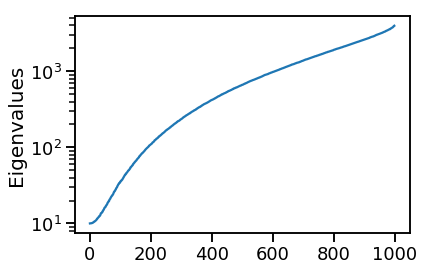

In [25]:
eigs = np.linalg.eigvals(A)
# print(eigs)
plt.semilogy(np.unique(eigs))
plt.ylabel("Eigenvalues", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [26]:
import scipy.sparse.linalg as spsplin

res_hist = []
def callback(x):
    res_hist.append(np.linalg.norm(A @ x - b))
    
x, info = spsplin.cg(A, b, tol=1e-10, callback=callback)
print(np.linalg.norm(A @ x - b))
print(info)

3.059164723442146e-09
0


226


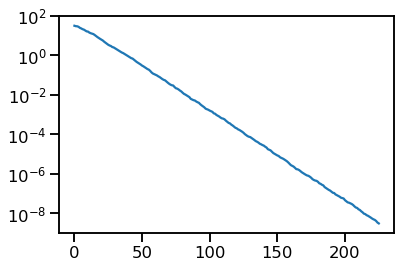

In [27]:
plt.semilogy(res_hist)
print(len(res_hist))

## Регуляризация задачи наименьших квадратов

$$ \| Ax - b \|_2^2 + \lambda \|x\|_2^2 \to \min_x $$ 

- Решение записывается аналогично

$$ (A^{\top}A + \lambda I)x = A^{\top}b $$

- Каким свойством теперь обладает матрица по сравнению с исходной постановкой без регуляризации?

In [28]:
m, n = 1000, 10
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)

In [29]:
lam = 1
x = spsplin.lsmr(A, b, damp=lam)[0]
print(np.linalg.norm(A @ x - b)**2 + lam * np.linalg.norm(x)**2)

7.69988931780442


In [30]:
lin_op = spsplin.LinearOperator((n, n), 
        matvec=lambda x: lam * x + A.T @ (A @ x))
x_cg, _ = spsplin.cg(lin_op, A.T @ b)
print(np.linalg.norm(A @ x_cg - b)**2 + lam * np.linalg.norm(x_cg)**2)

7.699889338125373
